In [1]:
import os
import cv2
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

from Models import HomographyRegressor, HomographyClassifier
from Models import classes_to_offsets, visualize_regression_result, visualize_classification_result
from Generator import generate_pair, get_random_images

In [2]:
# ============================================================
# Prepair Dataset
# ============================================================

from Generator import prepair_dataset

INPUT_DIR = "datasets/val2017"
PREPROCESSED_DIR = "datasets/val2017_preprocessed"

TARGET_SIZE = (320, 240)
# prepair_dataset(INPUT_DIR, PREPROCESSED_DIR, TARGET_SIZE)


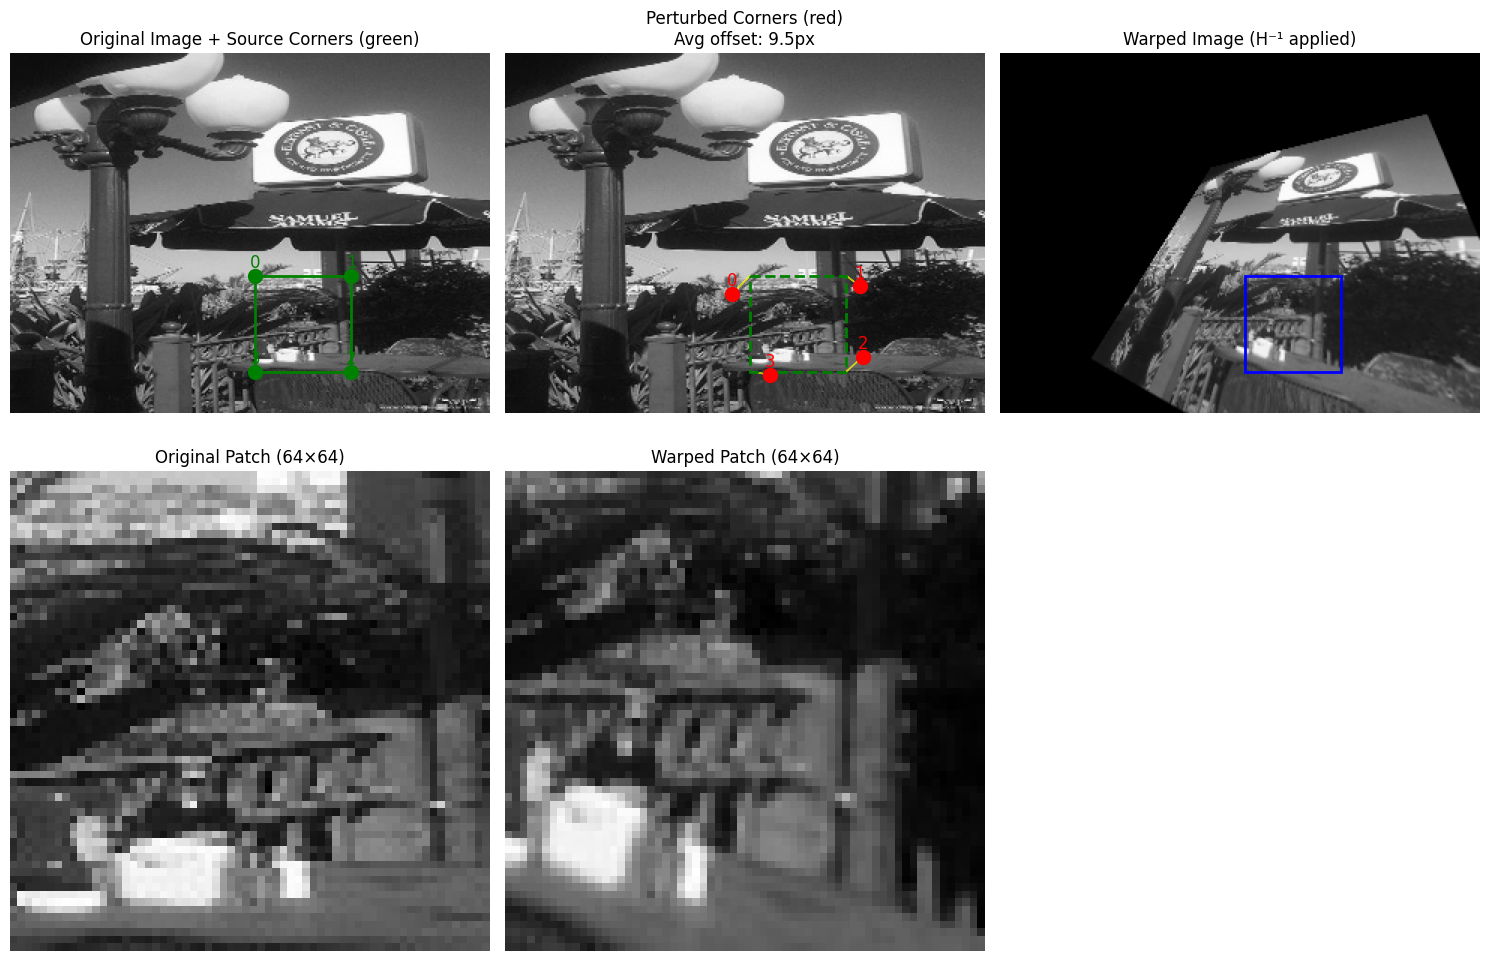


Corner offsets (Δx, Δy):
  Corner 0: (-12.0, +12.0) px
  Corner 1: (+9.0, +7.0) px
  Corner 2: (+11.0, -10.0) px
  Corner 3: (+13.0, +2.0) px


In [3]:
from Generator import visualize_generate_pair

# Run visualization
visualize_generate_pair(PREPROCESSED_DIR)

In [4]:
from Models import visualize_offset_sign

# visualize_offset_sign(PREPROCESSED_DIR)

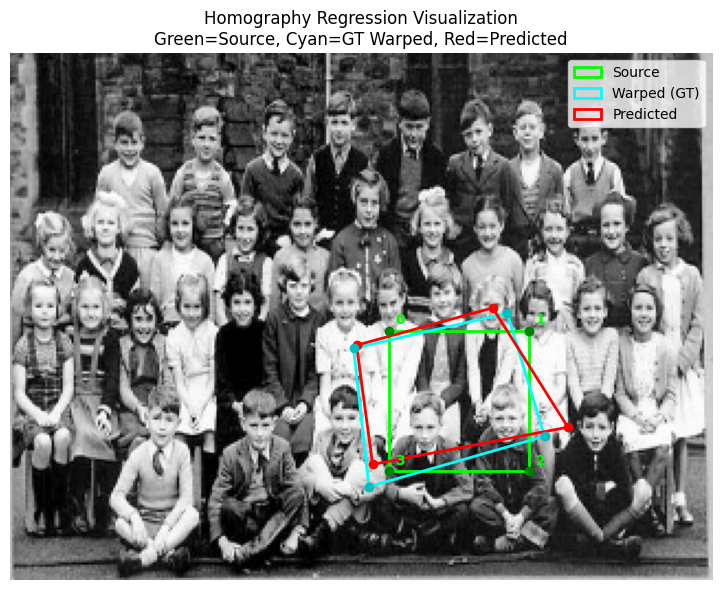

Ground Truth Offsets:
 [[-16.   8.]
 [-10.  -8.]
 [  7. -16.]
 [ -9.   7.]]
Predicted Offsets:
 [[ 14.64  -6.58]
 [ 16.65  10.46]
 [-17.63  20.1 ]
 [  7.32   3.14]]
Mean abs error per corner: [24.563 18.248]


In [15]:
# visualization of regression results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HomographyRegressor().to(device)
state = torch.load("checkpoints_homography_regressor_oneImage/checkpoint_epoch_50000.pth")["model_state_dict"]
# state = torch.load("checkpoints_homography_regressor_oneImage/h_regressor_ep50000_I1.pth")
model.load_state_dict(state)
model.eval()

# img = cv2.imread("datasets/val2017_preprocessed/000000002299.jpg", cv2.IMREAD_GRAYSCALE)
img = get_random_images(image_dir=PREPROCESSED_DIR)[0]
visualize_regression_result(model=model, image=img)

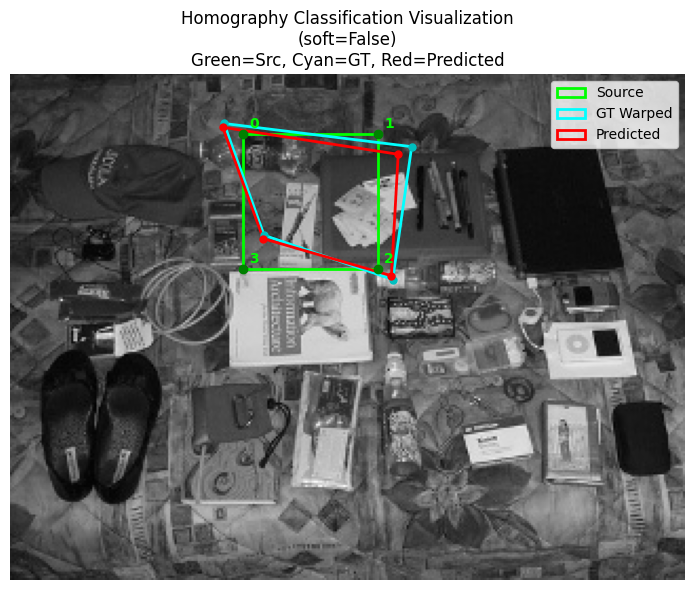

Ground Truth Offsets:
 [[ -9.  -5.]
 [ 16.   6.]
 [  7.   5.]
 [ 10. -16.]]
Predicted Offsets:
 [[ -9.6  -3.2]
 [  9.6   9.6]
 [  6.4   3.2]
 [  9.6 -14.4]]
Mean Abs Error per corner [px]: [2.  2.2]
Overall Mean Abs Error: 2.100 px


np.float32(2.1000001)

In [17]:
# visualization of classification results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HomographyClassifier(num_classes=21, class_dim=8).to(device)
state = torch.load("checkpoints_homography_classify/checkpoint_epoch_30000.pth")["model_state_dict"]
# state = torch.load("checkpoints_homography_clasify_oneImage/h_clasify_ep50000_I1.pth")
model.load_state_dict(state)
model.eval()

# img = cv2.imread("datasets/val2017_preprocessed/000000002299.jpg", cv2.IMREAD_GRAYSCALE)
img = get_random_images(image_dir=PREPROCESSED_DIR)[0]
visualize_classification_result(model=model, image=img, soft_decode=False)
# visualize_classification_result_dataloader(
#     model=model,
#     dataloader=dataloader,
#     num_samples=3,
#     soft_decode=True,
#     device=device
# )

In [7]:
# -------------------------
# EVALUACIJSKI MODUL
# -------------------------


# --- 1) Generiranje testnega nabora (~100 slik × 10 primerov) ---
def generate_test_set(images, n_images=100, samples_per_image=10,
                      window_size=64, margin=16, disp_range=(-16, 16), seed=42):
    """
    images: lista numpy sivinskih slik
    n_images: koliko različnih izvornih slik izbrati (max len(images))
    samples_per_image: število primerov na sliko
    returns: lista sample dictov:
      {
        'image': full_image,
        'pair': pair (2chan 64x64 float32),
        'offsets': gt_offsets (4x2 float32),
        'src_corners': src_corners (4x2),
        'dst_corners': dst_corners (4x2),
        'x': x, 'y': y,
        'orig_patch': orig_patch,
        'warped_patch': warped_patch
      }
    """
    random.seed(seed)
    np.random.seed(seed)

    selected = images[:min(n_images, len(images))]
    samples = []
    for img in selected:
        for _ in range(samples_per_image):
            pair, offsets, src_corners, warped_full = generate_pair(img, window_size=window_size, margin=margin,
                                                                    disp_range=disp_range)
            dst_corners = src_corners + offsets
            # Find x,y from src_corners (top-left)
            x = int(src_corners[0, 0]);
            y = int(src_corners[0, 1])
            orig_patch = (img[y:y + window_size, x:x + window_size]).astype(np.uint8)
            warped_patch = (warped_full[y:y + window_size, x:x + window_size]).astype(np.uint8)
            samples.append({
                'image': img,
                'pair': pair,  # float32 [H,W,2] / normalized [0,1]
                'offsets': offsets.reshape(4, 2),
                'src_corners': src_corners,
                'dst_corners': dst_corners,
                'x': x, 'y': y,
                'orig_patch': orig_patch,
                'warped_patch': warped_patch
            })
    print(f"➡️ Generiranih {len(samples)} testnih primerov iz {len(selected)} slik.")
    return samples


# --- 2) RMSE utility ---
def corner_rmse(pred_offsets, gt_offsets):
    """
    pred_offsets, gt_offsets: (4,2) arrays
    return scalar RMSE over 8 values
    """
    diff = (pred_offsets - gt_offsets).astype(np.float32).reshape(-1)
    return float(np.sqrt(np.mean(diff ** 2) + 1e-12))


# --- 3) Eval: Nevronski model (regresor ali klasifikator) ---
def eval_model_on_testset(model, test_samples, device,
                          model_type='regressor',  # 'regressor' or 'classifier'
                          disp_range=(-16, 16), negate_pred=False,
                          soft_decode=False, batch_size=32):
    """
    model_type: 'regressor' -> model returns (B,8) offsets; 'classifier' -> logits (B,num_classes,8)
    negate_pred: if your regressor predicts negative offsets during training, set True
    soft_decode: if classifier, whether to soft-decode expected value
    returns: dict with 'rmses' list, 'per_sample' list of dicts with preds etc.
    """
    model.eval()
    results = {'rmses': [], 'per_sample': []}
    with torch.no_grad():
        for i in range(0, len(test_samples), batch_size):
            batch = test_samples[i:i + batch_size]
            pairs = np.stack([s['pair'] for s in batch], axis=0)  # (B,H,W,2)
            pairs_t = torch.from_numpy(pairs).permute(0, 3, 1, 2).float().to(device)  # (B,2,H,W)
            preds = model(pairs_t)
            if model_type == 'classifier':
                # preds shape (B, num_classes, 8)
                pred_offsets = classes_to_offsets(preds, disp_range, soft=soft_decode).cpu().numpy()  # (B,8)
            else:
                pred_offsets = preds.cpu().numpy()  # (B,8)
                if negate_pred:
                    pred_offsets = -pred_offsets
            # reshape Bx8 -> Bx4x2
            pred_offsets = pred_offsets.reshape(pred_offsets.shape[0], 4, 2)
            for j, s in enumerate(batch):
                rmse = corner_rmse(pred_offsets[j], s['offsets'])
                results['rmses'].append(rmse)
                results['per_sample'].append({
                    'pred_offsets': pred_offsets[j],
                    'gt_offsets': s['offsets'],
                    'src_corners': s['src_corners'],
                    'dst_corners_gt': s['dst_corners'],
                    'orig_patch': s['orig_patch'],
                    'warped_patch': s['warped_patch'],
                    'image': s['image'],
                    'x': s['x'], 'y': s['y'],
                    'rmse': rmse
                })
    return results


# --- 4) Klasični OpenCV pristop (SIFT/SURF/ORB + findHomography) ---
def estimate_homography_classical(orig_patch, warped_patch, min_matches=4):
    """
    SIFT-only homography estimator.
    Returns: (success:bool, H:ndarray|None, num_matches:int, message:str)
    """
    assert orig_patch.ndim == 2 and warped_patch.ndim == 2

    # create SIFT detector
    try:
        sift = cv2.SIFT_create()
    except Exception as e:
        return False, None, 0, f"SIFT not available: {e}"

    # detect and compute
    kp1, des1 = sift.detectAndCompute(orig_patch, None)
    kp2, des2 = sift.detectAndCompute(warped_patch, None)

    if des1 is None or des2 is None or len(kp1) < 2 or len(kp2) < 2:
        return False, None, 0, f"Not enough keypoints ({len(kp1) if kp1 else 0}, {len(kp2) if kp2 else 0})"

    # FLANN matcher for SIFT
    index_params = dict(algorithm=1, trees=5)  # KDTree
    search_params = dict(checks=50)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)

    try:
        knn_matches = matcher.knnMatch(des1, des2, k=2)
    except Exception as e:
        return False, None, 0, f"FLANN matching failed: {e}"

    # Lowe's ratio test
    good = []
    for m in knn_matches:
        if len(m) == 2:
            a, b = m
            if a.distance < 0.75 * b.distance:
                good.append(a)

    if len(good) < min_matches:
        return False, None, len(good), f"Too few good matches ({len(good)})"

    # build point arrays and estimate homography
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    try:
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    except Exception as e:
        return False, None, len(good), f"findHomography failed: {e}"

    if H is None:
        return False, None, len(good), "findHomography returned None"

    inliers = int(mask.sum()) if mask is not None else 0
    return True, H, len(good), f"SIFT: success, inliers={inliers}"


def eval_classical_on_testset(test_samples, fallback_identity=True,
                              use_256_for_classical=False):
    """
    Evaluate classical approach on list of test_samples (as generated).
    If use_256_for_classical: will upsample patches to 256x256 before detection (to help classical),
      then the computed corner error is rescaled (divided by 4) as requested.
    Returns results dict similar to eval_model_on_testset plus num_failures count.
    """
    results = {'rmses': [], 'per_sample': [], 'num_failures': 0, 'num_total': len(test_samples)}
    for s in test_samples:
        orig = s['orig_patch']
        warped = s['warped_patch']
        # optionally upsample to 256x256:
        scale_factor = 1
        if use_256_for_classical:
            target = 256
            scale_factor = target / orig.shape[0]
            orig_up = cv2.resize(orig, (target, target), interpolation=cv2.INTER_LINEAR)
            warped_up = cv2.resize(warped, (target, target), interpolation=cv2.INTER_LINEAR)
            ok, H, nm, msg = estimate_homography_classical(orig_up, warped_up)
            if ok:
                # we computed H that maps src->dst in upsampled coordinates.
                # To apply on original coordinates, adjust H for scaling:
                S = np.array([[1 / scale_factor, 0, 0], [0, 1 / scale_factor, 0], [0, 0, 1]])
                H_adj = S @ H @ np.linalg.inv(S)
                H_used = H_adj
            else:
                H_used = None
        else:
            ok, H, nm, msg = estimate_homography_classical(orig, warped)
            H_used = H if ok else None

        if H_used is None and fallback_identity:
            # identity homography => predicted dst corners = src_corners
            pred_dst = s['src_corners']
            results['num_failures'] += 1
            comment = 'fallback_identity'
        elif H_used is None:
            pred_dst = s['src_corners']
            comment = 'failed_no_fallback'
            results['num_failures'] += 1
        else:
            # apply H to src_corners (each point as homogenous)
            pts = s['src_corners'].reshape(-1, 2)
            ones = np.ones((pts.shape[0], 1))
            hom_pts = np.concatenate([pts, ones], axis=1).T  # 3x4
            mapped = (H_used @ hom_pts).T  # 4x3
            mapped = mapped[:, :2] / mapped[:, 2:3]
            pred_dst = mapped.astype(np.float32)
            comment = f"ok_matches={nm}"

        pred_offsets = pred_dst - s['src_corners']
        rmse = corner_rmse(pred_offsets, s['offsets'])
        # adjust RMSE if we used 256-upsample and user requested dividing by 4
        if use_256_for_classical:
            rmse = float(rmse / 4.0)

        results['rmses'].append(rmse)
        results['per_sample'].append({
            'pred_offsets': pred_offsets,
            'gt_offsets': s['offsets'],
            'src_corners': s['src_corners'],
            'dst_corners_gt': s['dst_corners'],
            'rmse': rmse,
            'comment': comment
        })
    return results


# --- 5) Plotting and statistics ---
def summarize_and_plot(
        results_dict,
        labels,
        outdir='eval_results',
        bins=40,
        save_plots=True,
        ymax=200
):
    """
    results_dict: list of results (each has 'rmses')
    labels: list of labels
    ymax: y-axis limit for boxplot + histogram (None = auto)
    """

    os.makedirs(outdir, exist_ok=True)

    rmse_arrays = [np.array(r['rmses'], dtype=np.float32) for r in results_dict]

    # ---- SUMMARY PRINT ----
    summary = {}
    for lab, arr, r in zip(labels, rmse_arrays, results_dict):
        mean = float(np.mean(arr))
        med = float(np.median(arr))
        std = float(np.std(arr))
        num = len(arr)
        num_fail = r.get('num_failures', 0)
        summary[lab] = {'mean': mean, 'median': med, 'std': std, 'n': num, 'failures': num_fail}
        print(f"--- {lab} --- n={num}, failures={num_fail}\n  mean={mean:.3f}, median={med:.3f}, std={std:.3f}")

    # ---- BOXPLOT ----
    plt.figure(figsize=(8, 5))
    # plt.boxplot(rmse_arrays, labels=labels, showfliers=True)
    plt.boxplot(rmse_arrays, tick_labels=labels, showfliers=True)

    if ymax is not None:
        plt.ylim(0, ymax)

    plt.ylabel("RMSE (px)")
    plt.title("RMSE boxplot")
    if save_plots:
        p = os.path.join(outdir, "rmse_boxplot.png")
        plt.savefig(p, dpi=150)
        print("➡️ Shrani:", p)
    plt.show()

    return summary


# -------------------------
# EXAMPLE uporabe (po treningu)
# -------------------------
# Predpostavke:
# - imaš naložen model (regressor ali classifier) kot 'model' v device
# - imaš seznam sivinskih slik 'images' (npr. get_random_images(...))
# - če uporabljaš classifier, nastavi model_type='classifier' pri eval_model_on_testset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HomographyRegressor().to(device)
# state = torch.load("checkpoints_homography_regressor_oneImage/checkpoint_epoch_50000.pth")["model_state_dict"]
state = torch.load("checkpoints_homography_regressor_oneImage/h_regressor_ep50000_I1.pth")
model.load_state_dict(state)

# Primer: generiraj testset
test_samples = generate_test_set(
    images=get_random_images(
        num_images=100,
        image_dir=PREPROCESSED_DIR
    ),
    n_images=100,
    samples_per_image=10,
    window_size=64,
    margin=16,
    disp_range=(-16, 16)
)

# Primer: ocena tvojega nevronskega modela (classifier ali regressor)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
model_type = 'regressor'  # ali 'regressor'
neg = False  # če tvoj regressor v treningu uči negativne pomike, nastavi True
model_results = eval_model_on_testset(
    model,
    test_samples,
    device,
    model_type=model_type,
    negate_pred=neg,
    soft_decode=True
)

# Primer: ocena klasičnega pristopa
classical_results = eval_classical_on_testset(
    test_samples,
    fallback_identity=True,
    use_256_for_classical=True
)

# Primer: primerjava in ploti
summary = summarize_and_plot(
    [model_results, classical_results],
    labels=[model.__class__.__name__, 'Classical_OpenCV'],
    outdir='eval_results',
    save_plots=False,
)


ValueError: operands could not be broadcast together with shapes (4,2,2) (4,2) 